# Setup
Die folgenden Code-Blöcke können genutzt werden, um die benötigten Abhängigkeiten zu installieren und zu importieren.

In [588]:
%%capture
%pip install -r ../requirements.txt

In [589]:
%%capture
%load_ext pretty_jupyter

In [590]:
%%capture
# Laden der eingesetzten Libraries
import os
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import sweetviz as sv
from IPython.display import display
from itables import init_notebook_mode
from sklearn.linear_model import LinearRegression

init_notebook_mode()

In [591]:
# Funktion zur Bestimmung des Geschlechts und Berechnung des Geburtstags
def parse_details(birth_number):
    birth_number_str = str(
        birth_number
    )  # Konvertiere birth_number zu einem String, falls notwendig
    year_prefix = "19"
    month = int(birth_number_str[2:4])
    gender = "female" if month > 12 else "male"
    if gender == "female":
        month -= 50
    year = int(year_prefix + birth_number_str[:2])
    day = int(birth_number_str[4:6])
    birth_day = datetime(year, month, day)
    return gender, birth_day


# Berechnung des Alters basierend auf einem Basisjahr
def calculate_age(birth_date, base_date=datetime(1999, 12, 31)):
    return (
            base_date.year
            - birth_date.year
            - ((base_date.month, base_date.day) < (birth_date.month, birth_date.day))
    )


# Regression metrics
def regression_results(y_true, y_pred):
    print('explained_variance: ', round(metrics.explained_variance_score(y_true, y_pred), 4))
    print('mean_squared_log_error: ', round(metrics.mean_squared_log_error(y_true, y_pred), 4))
    print('r2: ', round(metrics.r2_score(y_true, y_pred), 4))
    print('MAE: ', round(metrics.mean_absolute_error(y_true, y_pred), 4))
    print('MSE: ', round(metrics.mean_squared_error(y_true, y_pred), 4))
    print('RMSE: ', round(np.sqrt(metrics.mean_squared_error(y_true, y_pred)), 4))

# Aufgabenstellung
Inhalt der hier bearbeiteten und dokumentierten Mini-Challenge für das Modul «aml - Angewandtes Machine Learning» der FHNW ist die Entwicklung und Evaluierung von Aﬀinitätsmodellen für personalisierte Kreditkarten-Werbekampagnen im Auftrag einer Bank. Das Ziel der Authoren ist es also, mithilfe von Kunden- und Transaktionsdaten präzise Modelle zu erstellen, die die Wahrscheinlichkeit des Kreditkartenkaufs einer bestimmten Person vorhersagen.

# Laden der zur Verfügung gestellten Daten
[//]: # (-.- .tabset)

Zur Verfügung gestellt wurden 8 csv-Dateien von welchen die Beschreibung der erfassten Variablen unter dem folgenden Link eingesehen werden können: [PKDD'99 Discovery Challenge - Guide to the Financial Data Set](https://sorry.vse.cz/~berka/challenge/PAST/index.html). Nachfolgend werden diese csv-Dateien eingelesen.

In [592]:
account = pd.read_csv("./data/account.csv", sep=";", dtype={"date": "str"})
card = pd.read_csv("./data/card.csv", sep=";", dtype={"issued": "str"})
client = pd.read_csv("./data/client.csv", sep=";")
disp = pd.read_csv("./data/disp.csv", sep=";")
district = pd.read_csv("./data/district.csv", sep=";")
loan = pd.read_csv("./data/loan.csv", sep=";", dtype={"date": "str"})
order = pd.read_csv("./data/order.csv", sep=";")
trans = pd.read_csv("./data/trans.csv", sep=";", dtype={"date": "str", "bank": "str"})

# Transformationen & Explorative Datenanalyse
Im folgenden Abschnitt werden die geladenen Daten separat so transformiert, dass jede Zeile einer Observation und jede Spalte einer Variable im entsprechenden Datenformat entspricht, also ins Tidy-Format gebracht.

In [593]:
data_frames = {}

## Account
[//]: # (-.- .tabset)
Der Datensatz `accounts.csv` beinhaltet 4500 Observationen mit den folgenden Informationen über die Kontos der Bank:  
- `account_id`: die Kontonummer, 
- `district_id`: den Standort der entsprechenden Bankfiliale,
- `frequency`: die Frequenz der Ausstellung von Kontoauszügen (monatlich, wöchentlich, pro Transaktion) und 
- `date`: das Erstellungsdatum

In [594]:
account.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   account_id   4500 non-null   int64 
 1   district_id  4500 non-null   int64 
 2   frequency    4500 non-null   object
 3   date         4500 non-null   object
dtypes: int64(2), object(2)
memory usage: 140.8+ KB


In [595]:
print("Anzahl fehlender Werte:", sum(account.isnull().sum()))
print("Anzahl duplizierter Einträge:", account.duplicated().sum())

Anzahl fehlender Werte: 0
Anzahl duplizierter Einträge: 0


### Transformation
Nachfolgend wird die `date` Spalte des `account.csv`-Datensatzes in das entsprechende Datenformat geparsed und die Werte von `frequency` übersetzt und als Levels einer Kategorie definiert.

In [596]:
# parse date
account["date"] = pd.to_datetime(account["date"], format="%y%m%d")
# translate categories
account["frequency"] = account["frequency"].replace(
    {
        "POPLATEK MESICNE": "monthly",
        "POPLATEK TYDNE": "weekly",
        "POPLATEK PO OBRATU": "transactional",
    }
)

# convert column frequency to categorical
account["frequency"] = account["frequency"].astype("category")

# append account data to dataframe collection
data_frames["account.csv"] = account

# sample 5 random rows
account.sample(n=5)

,account_id,district_id,frequency,date
2533,4214,1,monthly,1996-03-21
3553,4454,63,monthly,1996-12-21
2041,1376,64,monthly,1995-09-20
964,73,72,monthly,1993-11-08
2842,72,1,weekly,1996-06-20


In [597]:
%%capture
# generate sweetviz report
svReport_account = sv.analyze(account)
svReport_account.show_html(filepath="./reports/accounts.html", open_browser=False)

### Distrikt
Hier zu sehen ist die Verteilung der Distrikte pro Bankkonto. Ersichtlich ist, dass im Distrikt 1 mit Abstand am meisten Bankkontos geführt werden. Die darauf folgenden Distrikte bewegen sich alle im Bereich zwischen ~250 - 50 Bankkonten.  

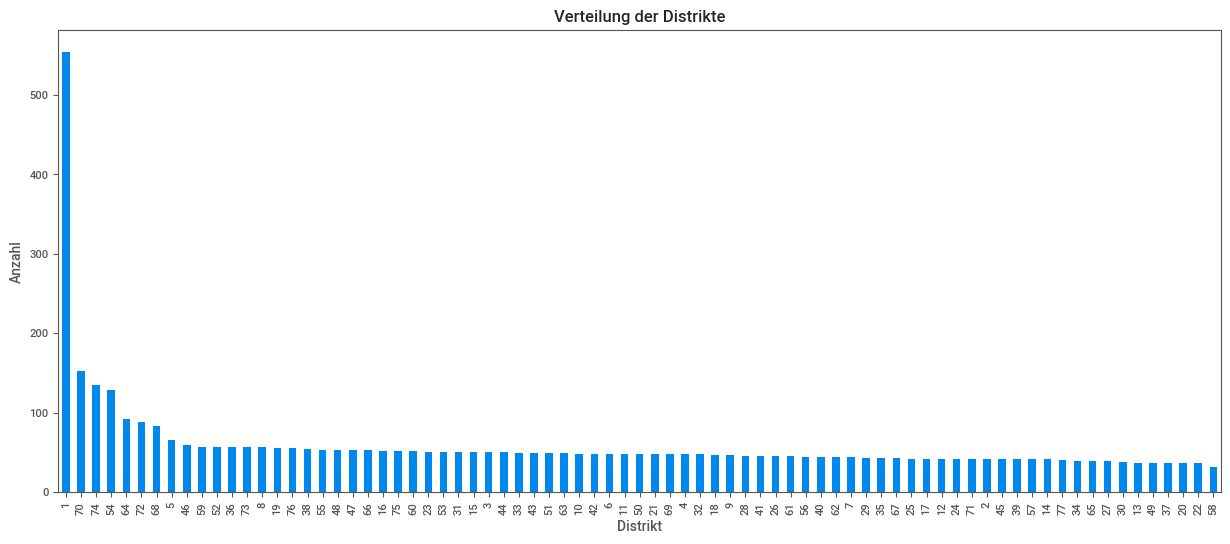

In [598]:
# plot the distribution of the district_ids and replace the id with it's name
plt.figure(figsize=(15, 6))
account["district_id"].value_counts().plot(kind="bar")
plt.title("Verteilung der Distrikte")
plt.xlabel("Distrikt")
plt.ylabel("Anzahl")
plt.show()

### Frequenz
Auf dieser Visualisierung zu sehen ist die Klassenverteilung der Frequenz der Ausstellung der Kontoauszüge. Die allermeisten Bankkonten besitzen eine monatliche Ausstellung.

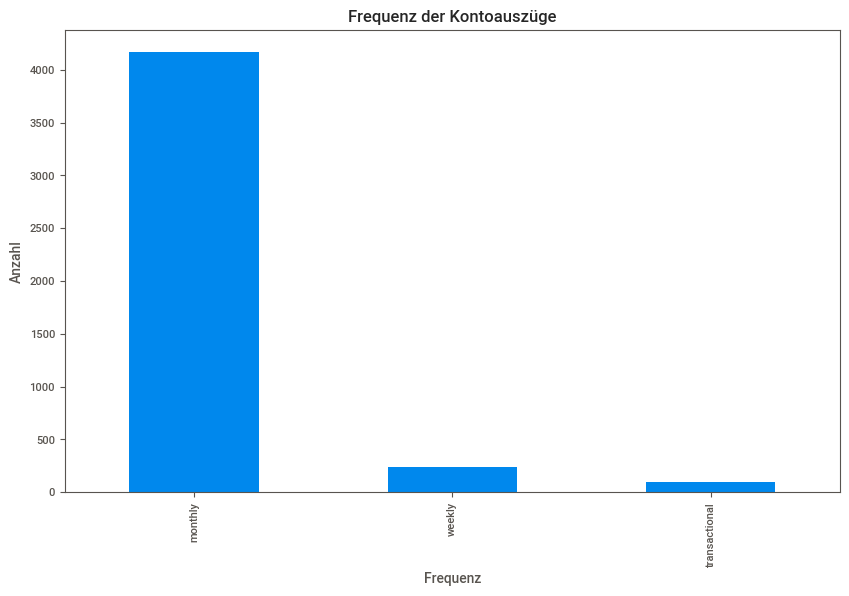

In [599]:
# Verteilung der Frequenz visualisieren
plt.figure(figsize=(10, 6))
account["frequency"].value_counts().plot(kind="bar")
plt.title("Frequenz der Kontoauszüge")
plt.xlabel("Frequenz")
plt.ylabel("Anzahl")
plt.show()

### Datum
Der hier dargestellte Plot zeigt die Verteilung der Kontoerstellungsdaten. Das erste Konto wurde im Jahr 1993 und das neuste im 1998 erstellt.  

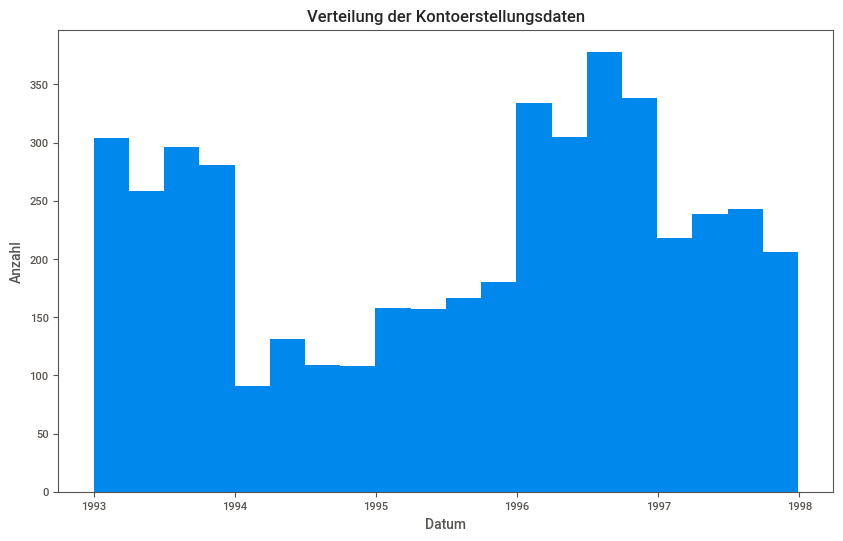

In [600]:
# plot date distribution
plt.figure(figsize=(10, 6))
plt.hist(account["date"], bins=20)
plt.title("Verteilung der Kontoerstellungsdaten")
plt.xlabel("Datum")
plt.ylabel("Anzahl")
plt.show()

### Korrelation & weitere Informationen
Die Korrelation sowie weitere Informationen zu den vorhandenen Daten können aus dem [SweetViz Report](./reports/accounts.html) entnommen werden. 

## Card
[//]: # (-.- .tabset)

Der Datensatz `card.csv` beinhaltet 892 Observationen mit den folgenden Informationen über die von der Bank herausgegebenen Kreditkarten:  
- `card_id`: die Kartennummer, 
- `disp_id`: die Zuordnung zum entsprechenden Bankkonto und -inhaber (Disposition),
- `type`: die Art der Kreditkarte (junior, classic, gold) und 
- `issued`: das Ausstellungsdatum

In [601]:
card.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 892 entries, 0 to 891
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   card_id  892 non-null    int64 
 1   disp_id  892 non-null    int64 
 2   type     892 non-null    object
 3   issued   892 non-null    object
dtypes: int64(2), object(2)
memory usage: 28.0+ KB


In [602]:
print("Anzahl fehlender Werte:", sum(card.isnull().sum()))
print("Anzahl duplizierter Einträge:", card.duplicated().sum())

Anzahl fehlender Werte: 0
Anzahl duplizierter Einträge: 0


### Transformation
Auch bei diesem Datensatz (`card.csv`) werden zunächst die Datentypen korrigiert um anschliessend die Inhalte entsprechend beschreiben zu können

In [603]:
# parse date
card["issued"] = pd.to_datetime(card["issued"].str[:6], format="%y%m%d")
# convert type to categorical
card["type"] = card["type"].astype("category")
# append to dataframes collection
data_frames["card.csv"] = card

card.sample(n=5)

,card_id,disp_id,type,issued
427,1105,11237,classic,1997-12-13
213,105,590,classic,1997-01-17
187,294,1861,classic,1996-12-04
651,1076,10604,gold,1998-07-27
794,295,1864,classic,1998-10-26


In [604]:
%%capture
# generate sweetviz report
svReport_card = sv.analyze(card)
svReport_card.show_html(filepath="./reports/card.html", open_browser=False)

### Kartentyp
Hier dargestellt ist die Klassenverteilung der Kartentypen. Die meisten Karteninhaber besitzen eine klassische Kreditkarte, gefolgt von ~180 junior- und ~100 gold Karten.  

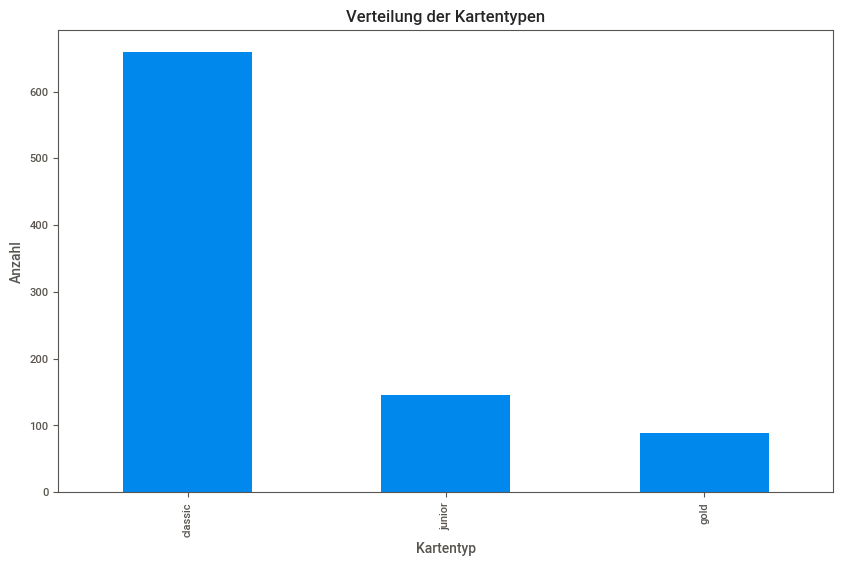

In [605]:
# plot distribution of type
plt.figure(figsize=(10, 6))
card["type"].value_counts().plot(kind="bar")
plt.title("Verteilung der Kartentypen")
plt.xlabel("Kartentyp")
plt.ylabel("Anzahl")
plt.show()

### Ausstellungsdatum
Hier dargestellt ist die Häufigkeit von Kreditkartenausstellungen pro Monat. Erkennbar ist eine steigende Tendenz mit einem Rückgang in den Monaten Februar - April 1997.  

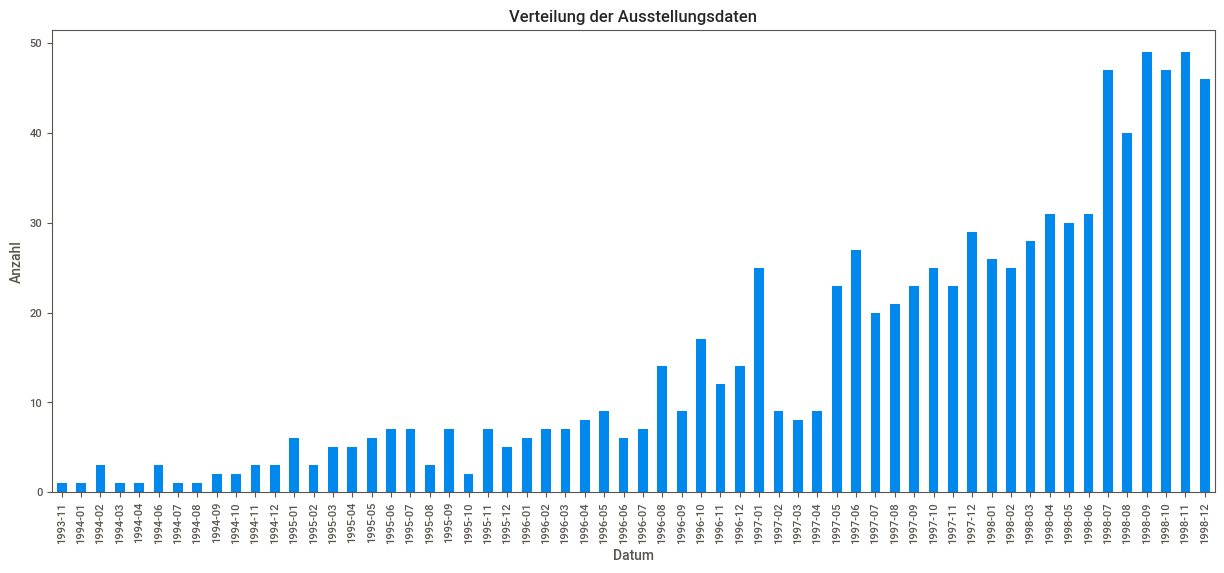

In [606]:
# plot issued date per month and year
plt.figure(figsize=(15, 6))
card["issued"].dt.to_period("M").value_counts().sort_index().plot(kind="bar")
plt.title("Verteilung der Ausstellungsdaten")
plt.xlabel("Datum")
plt.ylabel("Anzahl")
plt.show()

### Korrelation & weitere Informationen
Die Korrelation sowie weitere Informationen zu den vorhandenen Daten können aus dem [SweetViz Report](./reports/card.html) entnommen werden.

## Client
[//]: # (-.- .tabset)

Der Datensatz `client.csv` beinhaltet 5369 Observationen mit den folgenden Informationen über die Kunden der Bank:  
- `client_id`: die Kundennummer, 
- `birth_number`: eine Kombination aus Geburtsdatum und Geschlecht sowie
- `district_id`: die Adresse  

In [607]:
client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5369 entries, 0 to 5368
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   client_id     5369 non-null   int64
 1   birth_number  5369 non-null   int64
 2   district_id   5369 non-null   int64
dtypes: int64(3)
memory usage: 126.0 KB


In [608]:
print("Anzahl fehlender Werte:", sum(client.isnull().sum()))
print("Anzahl duplizierter Einträge:", client.duplicated().sum())

Anzahl fehlender Werte: 0
Anzahl duplizierter Einträge: 0


### Transformation
Die Spalte `birth_number` des `client.csv`-Datensatzes codiert 3 Features der Bankkunden: Geschlecht, Geburtsdatum und damit auch das Alter. Diese Informationen werden mithilfe der zuvor definierten Funktionen `parse_details()` und `calculate_age` extrahiert.

In [609]:
# Geburtstag & Geschlecht aus birth_number extrahieren
client["gender"], client["birth_day"] = zip(
    *client["birth_number"].apply(parse_details)
)
client["gender"] = client["gender"].astype("category")
# Alter berechnen
client["age"] = client["birth_day"].apply(calculate_age)

# Spalte birth_number entfernen
client = client.drop(columns=["birth_number"])

data_frames["client.csv"] = client

# Sample 5 random rows
client.sample(n=5)

,client_id,district_id,gender,birth_day,age
1194,1256,46,female,1955-11-13,44
5036,9717,52,female,1952-11-10,47
899,949,3,male,1976-07-27,23
860,907,51,male,1948-03-11,51
1727,1832,1,female,1966-07-31,33


In [610]:
%%capture
svReport_client = sv.analyze(client)
svReport_client.show_html(filepath="./reports/client.html", open_browser=False)

### Geschlecht
Hier dargestellt ist die Verteilung des Geschlechts der Bankkunden. Das Geschlecht der erfassten Bankkunden ist fast gleichverteilt mit einem etwas kleineren Frauenanteil.  

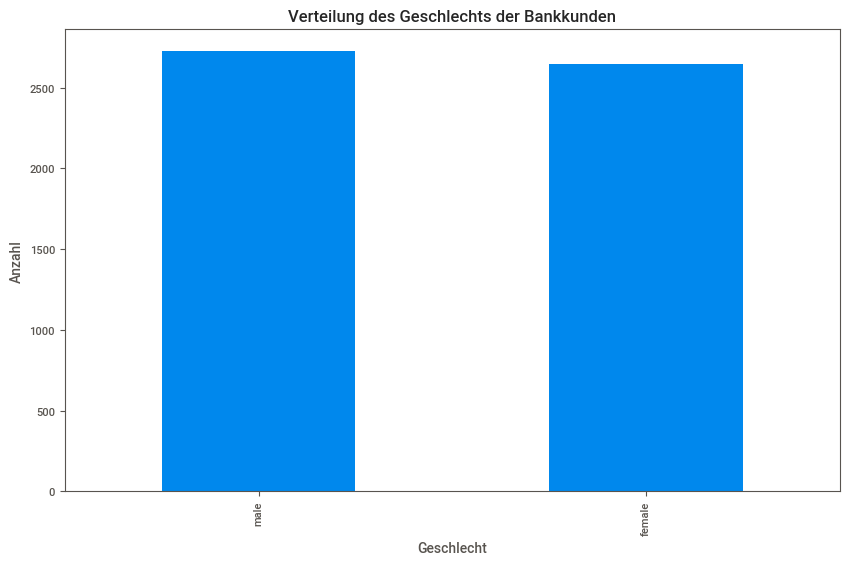

In [611]:
# plot distribution of gender
plt.figure(figsize=(10, 6))
gender_distribution = client['gender'].value_counts().plot(kind='bar')
plt.title('Verteilung des Geschlechts der Bankkunden')
plt.xlabel('Geschlecht')
plt.ylabel('Anzahl')
plt.show()

### Alter
Nachfolgend abgebildet ist die Verteilung des Alters der Bankkunden. Die jüngste erfasste Person ist 12 Jahre alt und die älteste 88. 

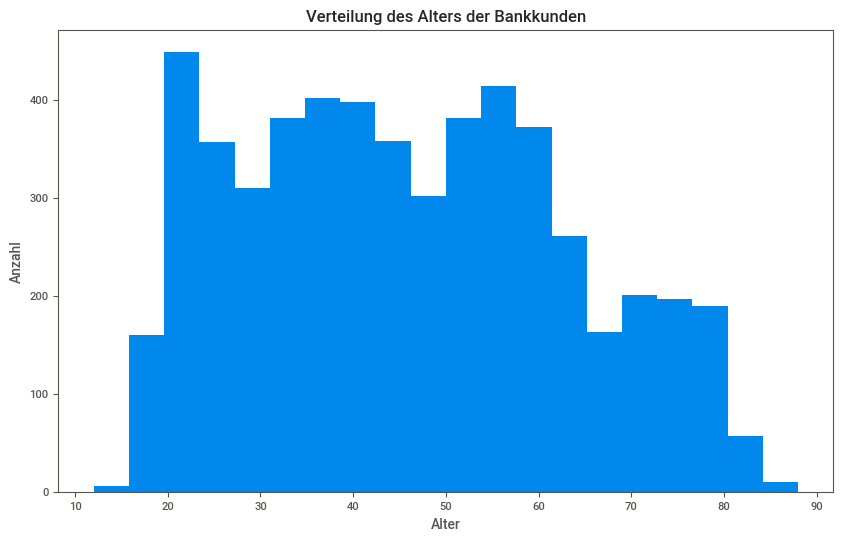

In [612]:
# plot distribution of age
plt.figure(figsize=(10, 6))
client["age"].plot(kind="hist", bins=20)
plt.title("Verteilung des Alters der Bankkunden")
plt.xlabel("Alter")
plt.ylabel("Anzahl")
plt.show()

### Korrelation & weitere Informationen
Die Korrelation sowie weitere Informationen zu den vorhandenen Daten können aus dem [SweetViz Report](./reports/client.html) entnommen werden.

## Disp
[//]: # (-.- .tabset)

Der Datensatz `disp.csv` beinhaltet 5369 Observationen mit den folgenden Informationen über die Dispositionen der Bank:  
- `disp_id`: der Identifikationsschlüssel der Disposition,
- `client_id`: die Kundennummer,
- `account_id`: die Kontonummer,
- `type`: die Art der Disposition (Inhaber, Benutzer)

In [613]:
disp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5369 entries, 0 to 5368
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   disp_id     5369 non-null   int64 
 1   client_id   5369 non-null   int64 
 2   account_id  5369 non-null   int64 
 3   type        5369 non-null   object
dtypes: int64(3), object(1)
memory usage: 167.9+ KB


In [614]:
print("Anzahl fehlender Werte:", sum(disp.isnull().sum()))
print("Anzahl duplizierter Einträge:", disp.duplicated().sum())

Anzahl fehlender Werte: 0
Anzahl duplizierter Einträge: 0


### Transformation
Auch die Variablen des Datensatzes `disp.csv` werden in die korrekten Datentypen übertragen. 

In [615]:
# Spalte type als Kategorie speichern 
disp["type"] = disp["type"].astype("category")

data_frames["disp.csv"] = disp

# random sample
disp.sample(n=5)

,disp_id,client_id,account_id,type
4191,4433,4433,3678,OWNER
5153,10942,11250,9138,OWNER
4424,4681,4681,3884,OWNER
3393,3581,3581,2966,OWNER
3744,3956,3956,3268,OWNER


In [616]:
%%capture
svReport_disp = sv.analyze(disp)
svReport_disp.show_html(filepath="./reports/disp.html", open_browser=False)

### Typ der Disposition
Hier dargestellt ist die Verteilung der Art der Dispositionen. 4500 Kunden sind Inhaber eines Kontos und 896 sind Disponenten. 

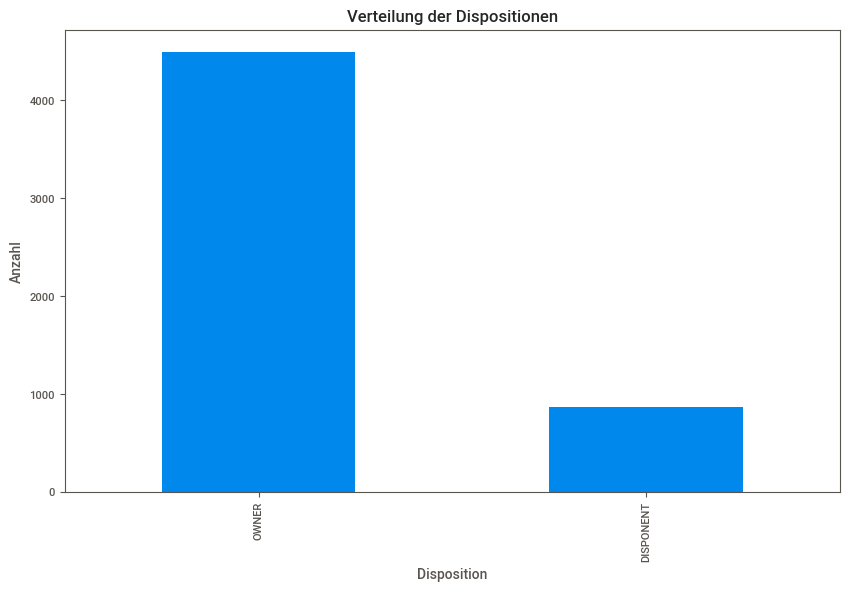

In [617]:
# plot distribution of kind
plt.figure(figsize=(10, 6))
disp["type"].value_counts().plot(kind="bar")
plt.title("Verteilung der Dispositionen")
plt.xlabel("Disposition")
plt.ylabel("Anzahl")
plt.show()

In [618]:
# remove disponents
disp = disp[disp["type"] == "OWNER"]

### Korrelation & weitere Informationen
Die Korrelation sowie weitere Informationen zu den vorhandenen Daten können aus dem [SweetViz Report](./reports/disp.html) entnommen werden.

## District
[//]: # (-.- .tabset)

Der Datensatz `district.csv` beinhaltet 77 Observationen mit den folgenden demografischen Informationen:  
- `A1`: die ID des Distrikts, 
- `A2`: der Name des Distrikts,
- `A3`: die Region,
- `A4`: die Anzahl der Einwohner,
- `A5`: die Anzahl der Gemeinden mit < 499 Einwohner,
- `A6`: die Anzahl der Gemeinden mit 500 - 1999 Einwohner,
- `A7`: die Anzahl der Gemeinden mit 2000 - 9999 Einwohner,
- `A8`: die Anzahl der Gemeinden mit >10000 Einwohner,
- `A9`: die Anzahl Städte,
- `A10`: das Verhältnis von städtischen Einwohnern,
- `A11`: das durchschnittliche Einkommen,
- `A12`: die Arbeitslosenrate vom Jahr 95,
- `A13`: die Arbeitslosenrate vom Jahr 96,
- `A14`: die Anzahl von Unternehmer pro 1000 Einwohner,
- `A15`: die Anzahl von begangenen Verbrechen im Jahr 95,
- `A16`: die Anzahl von begangenen Verbrechen im Jahr 96, 

In [619]:
district.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A1      77 non-null     int64  
 1   A2      77 non-null     object 
 2   A3      77 non-null     object 
 3   A4      77 non-null     int64  
 4   A5      77 non-null     int64  
 5   A6      77 non-null     int64  
 6   A7      77 non-null     int64  
 7   A8      77 non-null     int64  
 8   A9      77 non-null     int64  
 9   A10     77 non-null     float64
 10  A11     77 non-null     int64  
 11  A12     77 non-null     object 
 12  A13     77 non-null     float64
 13  A14     77 non-null     int64  
 14  A15     77 non-null     object 
 15  A16     77 non-null     int64  
dtypes: float64(2), int64(10), object(4)
memory usage: 9.8+ KB


In [620]:
print("Anzahl fehlender Werte:", sum(district.isnull().sum()))
print("Anzahl duplizierter Einträge:", district.duplicated().sum())

Anzahl fehlender Werte: 0
Anzahl duplizierter Einträge: 0


### Transformation
Zunächst werden die Spaltennamen in sprechendere übersetzt.

In [621]:
# Spalten umbenennen
district = district.rename(
    columns={
        "A1": "district_id",
        "A2": "district_name",
        "A3": "region",
        "A4": "num_of_habitat",
        "A5": "num_of_small_town",
        "A6": "num_of_medium_town",
        "A7": "num_of_big_town",
        "A8": "num_of_bigger_town",
        "A9": "num_of_city",
        "A10": "ratio_of_urban",
        "A11": "average_salary",
        "A12": "unemploy_rate95",
        "A13": "unemploy_rate96",
        "A14": "n_of_enterpren_per1000_inhabit",
        "A15": "no_of_crimes95",
        "A16": "no_of_crimes96",
    }
)[
    [
        "district_id",
        "district_name",
        "region",
        "num_of_habitat",
        "num_of_small_town",
        "num_of_medium_town",
        "num_of_big_town",
        "num_of_bigger_town",
        "num_of_city",
        "ratio_of_urban",
        "average_salary",
        "unemploy_rate95",
        "unemploy_rate96",
        "n_of_enterpren_per1000_inhabit",
        "no_of_crimes95",
        "no_of_crimes96",
    ]
]

district["region"] = district["region"].astype("category")
district["district_name"] = district["district_name"].astype("category")

Auffällig ist, dass nebst den Spalten `A2` (dem Namen) und `A3` (der Region) die Spalten `A12` und `A15` den Datentyp `object` erhalten. Das ist, weil jeweils ein fehlender Wert vorhanden ist, welcher mit einem `?` gekennzeichnet ist. 

In [622]:
# die fehlenden Werte anzeigen
district[district.isin(["?"]).any(axis=1)]

,district_id,district_name,region,num_of_habitat,num_of_small_town,num_of_medium_town,num_of_big_town,num_of_bigger_town,num_of_city,ratio_of_urban,average_salary,unemploy_rate95,unemploy_rate96,n_of_enterpren_per1000_inhabit,no_of_crimes95,no_of_crimes96
68,69,Jesenik,north Moravia,42821,4,13,5,1,3,48.4,8173,?,7.01,124,?,1358


Wir gehen davon aus, dass es sich hier um effektiv fehlende Werte handelt und nicht um zensierte Daten, also Werte, für welche der exakte Wert fehlt, aber trotzdem Informationen vorhanden sind. In diesem Fall, wenn die Variable mit den fehlenden Werten eine hohe Korrelation mit anderen Prediktoren aufweist, bietet es sich an, KNN oder eine einfache lineare Regression für die Imputation anzuwenden. [1] 

Die Korrelationsmatrix des [SweetViz Reports](./reports/district.html) zeigt, dass `unemploy_rate95` stark mit `unemploy_rate96` und `no_of_crimes95` mit `no_of_crimes96` korreliert. 

In [623]:
# die ? ersetzen mit NaN
district = district.replace("?", np.nan)

# Datentyp korrigieren
district["no_of_crimes95"] = district["no_of_crimes95"].astype(float)
district["unemploy_rate95"] = district["unemploy_rate95"].astype(float)

In [624]:
# Korrelation zwischen Arbeitslosenquote 95 und 96
district[["unemploy_rate95", "unemploy_rate96"]].corr()

,unemploy_rate95,unemploy_rate96
unemploy_rate95,1.000000,0.981521
unemploy_rate96,0.981521,1.000000


In [625]:
# Korrelation zwischen Anzahl Verbrechen 95 und 96
district[["no_of_crimes95", "no_of_crimes96"]].corr()

,no_of_crimes95,no_of_crimes96
no_of_crimes95,1.000000,0.998426
no_of_crimes96,0.998426,1.000000


Demnach werden nachfolgend zwei lineare Regressions-Modelle trainiert, um die fehlenden Werte zu imputieren.

In [626]:
# Zeilen filtern, sodass keine fehlenden Werte vorhanden sind
district_no_na = district[district["unemploy_rate95"].notnull()]

# Lineares regressions Modell erstellen 
lin_reg_unemploy = LinearRegression()

# Modell fitten
lin_reg_unemploy.fit(
    district_no_na["unemploy_rate96"].values.reshape(-1, 1),
    district_no_na["unemploy_rate95"].values,
)

# Modell evaluieren
regression_results(district_no_na["unemploy_rate95"],
                   lin_reg_unemploy.predict(district_no_na["unemploy_rate96"].values.reshape(-1, 1)))

explained_variance:  0.9634
mean_squared_log_error:  0.0051
r2:  0.9634
MAE:  0.231
MSE:  0.1002
RMSE:  0.3166


Der $R^2$ Wert von $0.9634$ versichert, damit ein stabiles Modell für die Imputation erreicht zu haben. 

In [627]:
# Lineares regressions Modell erstellen 
lin_reg_crime = LinearRegression()

# Modell fitten
lin_reg_crime.fit(
    district_no_na["no_of_crimes96"].values.reshape(-1, 1),
    district_no_na["no_of_crimes95"].values,
)

# Modell evaluieren
regression_results(district_no_na["no_of_crimes95"],
                   lin_reg_crime.predict(district_no_na["no_of_crimes96"].values.reshape(-1, 1)))

explained_variance:  0.9969
mean_squared_log_error:  0.0219
r2:  0.9969
MAE:  383.5379
MSE:  303529.5111
RMSE:  550.9351


Auch hier mit einem $R^2$ Wert von $0.9969$ gehen wir davon aus, damit ein stabiles Modell für die Imputation erreicht zu haben. Somit werden nachfolgend die beiden Modelle genutzt, um die fehlenden Werte einzufüllen.

In [628]:
# Vorhersage der fehlenden Werte
district.loc[district["no_of_crimes95"].isnull(), "no_of_crimes95"] = lin_reg_crime.predict(
    district[district["no_of_crimes95"].isnull()]["no_of_crimes96"].values.reshape(-1, 1)
)

district.loc[district["unemploy_rate95"].isnull(), "unemploy_rate95"] = lin_reg_unemploy.predict(
    district[district["unemploy_rate95"].isnull()]["unemploy_rate96"].values.reshape(-1, 1)
)

In [629]:
data_frames["district.csv"] = district

district.sample(n=5)

,district_id,district_name,region,num_of_habitat,num_of_small_town,num_of_medium_town,num_of_big_town,num_of_bigger_town,num_of_city,ratio_of_urban,average_salary,unemploy_rate95,unemploy_rate96,n_of_enterpren_per1000_inhabit,no_of_crimes95,no_of_crimes96
16,17,Pelhrimov,south Bohemia,74062,99,15,4,2,7,61.4,8114,2.38,2.62,119,1003.0,1181
26,27,Plzen - jih,west Bohemia,67298,71,19,10,0,7,43.8,8561,0.65,1.29,110,1029.0,1127
37,38,Louny,north Bohemia,85852,41,23,4,2,4,59.8,8965,7.08,8.23,104,2653.0,2822
72,73,Opava,north Moravia,182027,17,49,12,2,7,56.4,8746,3.33,3.74,90,4355.0,4433
44,45,Jicin,east Bohemia,77917,85,19,6,1,5,53.5,8390,2.28,2.89,132,2080.0,2122


In [630]:
district.isnull().sum()

district_id                       0
district_name                     0
region                            0
num_of_habitat                    0
num_of_small_town                 0
num_of_medium_town                0
num_of_big_town                   0
num_of_bigger_town                0
num_of_city                       0
ratio_of_urban                    0
average_salary                    0
unemploy_rate95                   0
unemploy_rate96                   0
n_of_enterpren_per1000_inhabit    0
no_of_crimes95                    0
no_of_crimes96                    0
dtype: int64

### EDA
Es gibt keine Duplikate und somit 77 unterschiedliche Namen der Distrikte. Diese sind auf 8 Regionen verteilt, wobei die meisten in south Moravia und die wenigsten in Prague liegen. Der Distrikt mit den wenigsten Einwohnern zählt 42821, im Vergleich zu demjenigen mit den meisten: 1204953, wobei die nächst kleinere Ortschaft 102609 Einwohner zählt. Weitere Informationen zu den vorhandenen Daten können aus dem [SweetViz Report](./reports/district.html) entnommen werden. 

In [631]:
%%capture
svReport_district = sv.analyze(district)
svReport_district.show_html(filepath="./reports/district.html", open_browser=False)

## Loan
[//]: # (-.- .tabset)

Der Datensatz `loan.csv` beinhaltet 682 Observationen mit den folgenden Informationen über die vergebenen Darlehen der Bank:  
- `loan_id`: ID des Darlehens,
- `account_id`: die Kontonummer,
- `date`: das Datum, wann das Darlehen gewährt wurde,
- `amount`: der Betrag,
- `duration`: die Dauer des Darlehens,
- `payments`: die höhe der monatlichen Zahlungen und
- `status`: der Rückzahlungsstatus (A: ausgeglichen, B: Vertrag abgelaufen aber nicht fertig bezahlt, C: laufender Vertrag und alles in Ordnung, D: laufender Vertrag und Kunde verschuldet)


In [632]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 682 entries, 0 to 681
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   loan_id     682 non-null    int64  
 1   account_id  682 non-null    int64  
 2   date        682 non-null    object 
 3   amount      682 non-null    int64  
 4   duration    682 non-null    int64  
 5   payments    682 non-null    float64
 6   status      682 non-null    object 
dtypes: float64(1), int64(4), object(2)
memory usage: 37.4+ KB


In [633]:
print("Anzahl fehlender Werte:", sum(loan.isnull().sum()))
print("Anzahl duplizierter Einträge:", loan.duplicated().sum())

Anzahl fehlender Werte: 0
Anzahl duplizierter Einträge: 0


### Transformation
Auch für den `loan.csv` Datensatz werden zunächst Datenformate korrigiert und Kategorien übersetzt. Anschliessend wird überprüft, ob ein Bankkonto mehrere Darlehen besitzt.  

In [634]:
# Datum parsen
loan["date"] = pd.to_datetime(loan["date"], format="%y%m%d")

# Kategorien übersetzen
loan["status"] = loan["status"].map(
    {
        "A": "contract finished",
        "B": "finished contract, loan not paid",
        "C": "running contract",
        "D": "client in debt",
    }
)

loan["status"] = loan["status"].astype("category")

In [635]:
# Anzahl der Darlehen pro Kontonummer berechnen
num_of_loan_df = (
    loan.groupby("account_id")
    .size()
    .reset_index(name="num_of_loan")
    .sort_values(by="num_of_loan", ascending=False)
)

In [636]:
# Überprüfen, ob jedes Konto nur ein Darlehen hat
num_of_loan_df["num_of_loan"].value_counts()

num_of_loan
1    682
Name: count, dtype: int64

Von allen Bankkontos, die ein Darlehen aufgenommen haben, hat jedes Konto genau ein Darlehen zugewiesen.

In [637]:
# Assign the resulting DataFrame to a dictionary for storage
data_frames["loan.csv"] = loan

# Sample 5 random rows from the joined DataFrame
display(loan.sample(n=5))

,loan_id,account_id,date,amount,duration,payments,status
656,5368,2073,1998-10-05,44640,24,1860.0,running contract
366,5790,4033,1997-03-20,84288,48,1756.0,running contract
437,7001,9859,1997-08-10,300600,60,5010.0,running contract
464,6196,5837,1997-09-14,177804,36,4939.0,running contract
187,7057,10093,1995-10-20,231696,36,6436.0,contract finished


In [638]:
%%capture
svReport_loan = sv.analyze(loan)
svReport_loan.show_html(filepath="./reports/loan.html", open_browser=False)

### Ausstellungsdatum
Nachfolgend dargestellt ist die Verteilung der Darlehensausstellungsdaten. das erste Darlehen wurde im Juli 1993 ausgestellt und das neuste im Dezember 1998. 

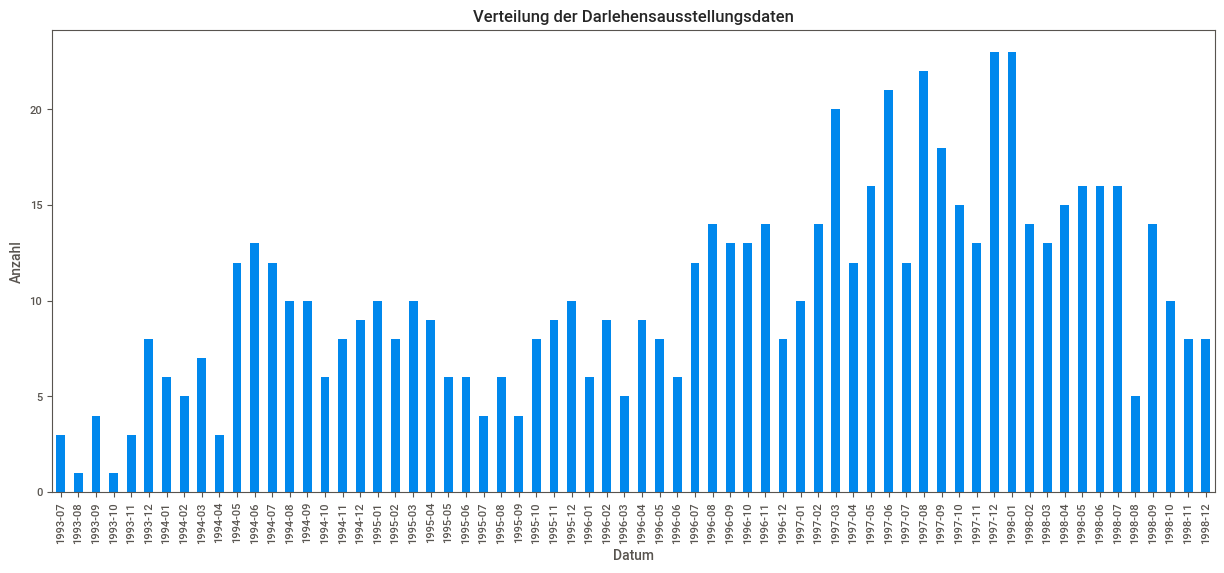

In [639]:
# plot distribution of date
plt.figure(figsize=(15, 6))
loan["date"].dt.to_period("M").value_counts().sort_index().plot(kind="bar")
plt.title("Verteilung der Darlehensausstellungsdaten")
plt.xlabel("Datum")
plt.ylabel("Anzahl")
plt.show()

### Dauer
Hier ersichtlich ist die Verteilung der Dauer der Darlehen. Sie ist fast gleichverteilt über die 5 möglichen Optionen. 

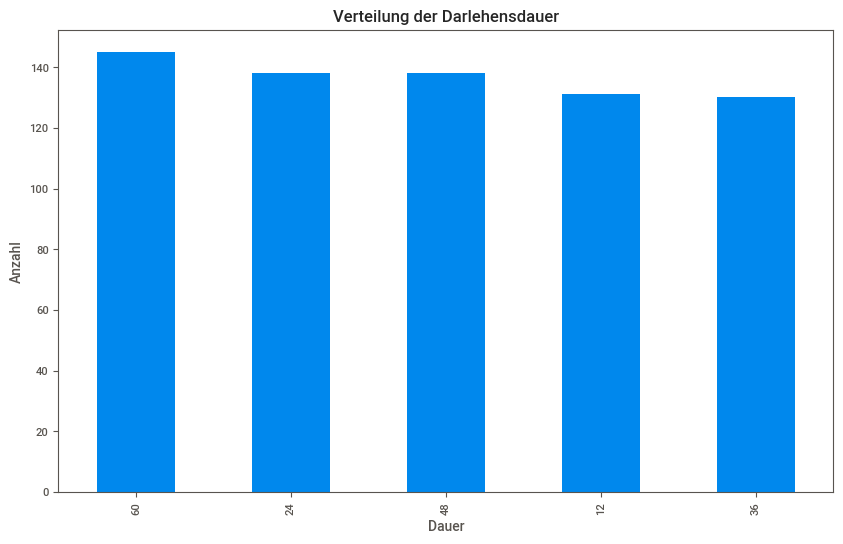

In [640]:
# plot duration distribution
plt.figure(figsize=(10, 6))
loan["duration"].value_counts().plot(kind="bar")
plt.title("Verteilung der Darlehensdauer")
plt.xlabel("Dauer")
plt.ylabel("Anzahl")
plt.show()

### Betrag
Hier dargestellt ist die Verteilung der Darlehensbeträge. Nur wenige Darlehensbeträge sind höher als 400000 wobei die meisten um die 100000 betragen. 

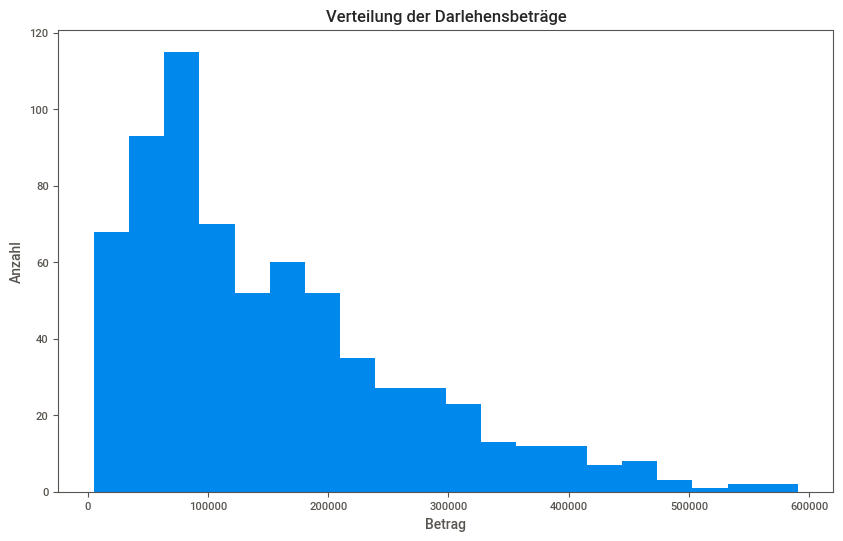

In [641]:
# plot amount
plt.figure(figsize=(10, 6))
loan["amount"].plot(kind="hist", bins=20)
plt.title("Verteilung der Darlehensbeträge")
plt.xlabel("Betrag")
plt.ylabel("Anzahl")
plt.show()

### Status
Der nachfolgende Plot zeigt die Klassenverteilung vom Darlehensstatus. Die meisten (~400) sind laufend und ok, rund 200 sind abgeschlossen, die Kunden von ~50 Darlehen sind verschuldet und etwas weniger wurden abgeschlossen, ohne fertig abbezahlt worden zu sein.  

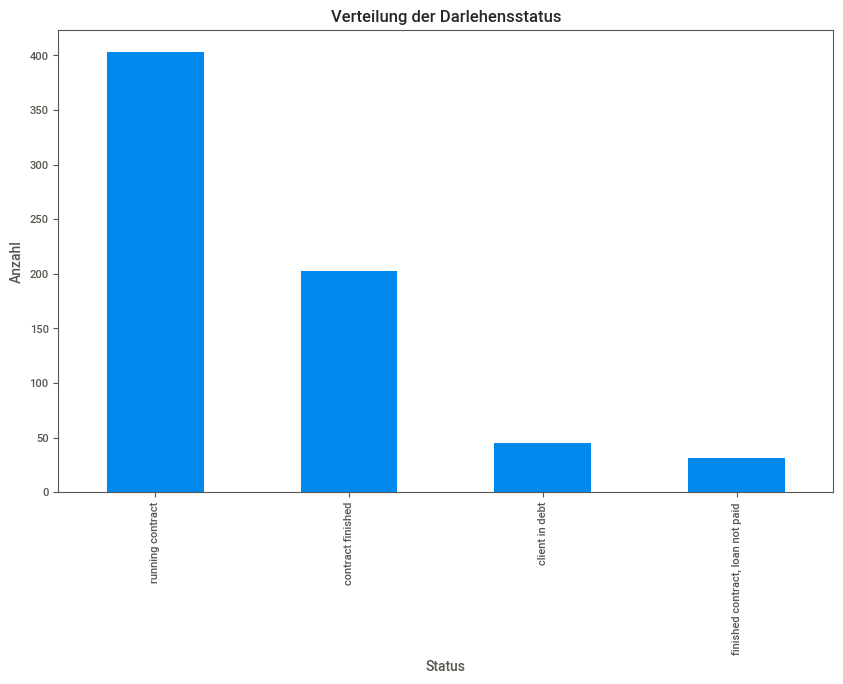

In [642]:
# plot status distribution
plt.figure(figsize=(10, 6))
loan["status"].value_counts().plot(kind="bar")
plt.title("Verteilung der Darlehensstatus")
plt.xlabel("Status")
plt.ylabel("Anzahl")
plt.show()

### Zahlungen
Hier ersichtlich ist die Verteilung der monatlichen Zahlungen der Darlehen. Die kleinste monatliche Zahlung beträgt 304 und die höchste 9910.

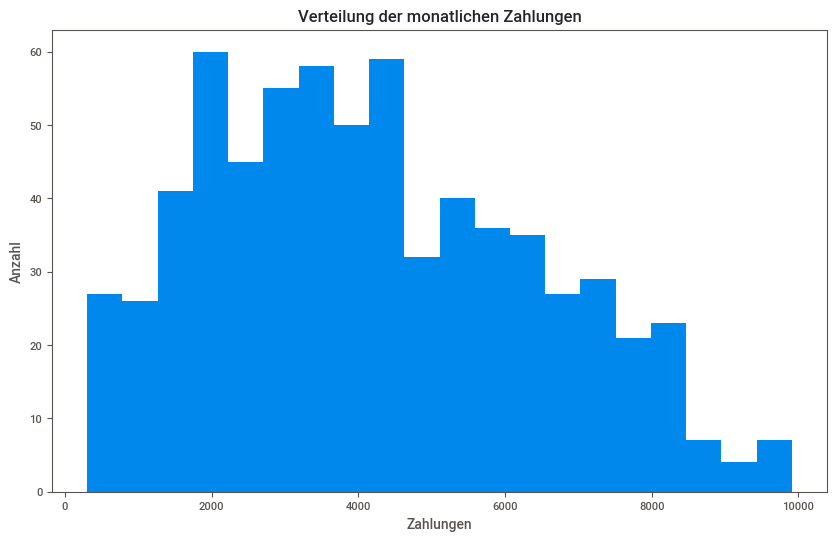

In [643]:
# plot payments
plt.figure(figsize=(10, 6))
loan["payments"].plot(kind="hist", bins=20)
plt.title("Verteilung der monatlichen Zahlungen")
plt.xlabel("Zahlungen")
plt.ylabel("Anzahl")
plt.show()

### Korrelation & weitere Informationen
Die Korrelation sowie weitere Informationen zu den vorhandenen Daten können aus dem [SweetViz Report](./reports/loan.html) entnommen werden.

## Order
[//]: # (-.- .tabset)

Der Datensatz `order.csv` beinhaltet 6471 Observationen mit den folgenden Informationen über die Daueraufträge eines Kontos:  
- `order_id`: die Nummer des Dauerauftrags,
- `account_id`: die Kontonummer von welchem der Auftrag stammt,
- `bank_to`: die empfangende Bank,
- `account_to`: das empfangende Konto, 
- `amount`: der Betrag,
- `k_symbol`: die Art des Auftrags (Versicherungszahlung, Haushalt, Leasing, Darlehen)


In [644]:
order.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6471 entries, 0 to 6470
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   order_id    6471 non-null   int64  
 1   account_id  6471 non-null   int64  
 2   bank_to     6471 non-null   object 
 3   account_to  6471 non-null   int64  
 4   amount      6471 non-null   float64
 5   k_symbol    6471 non-null   object 
dtypes: float64(1), int64(3), object(2)
memory usage: 303.5+ KB


In [645]:
print("Anzahl fehlender Werte:", sum(order.isnull().sum()))
print("Anzahl duplizierter Einträge:", order.duplicated().sum())

Anzahl fehlender Werte: 0
Anzahl duplizierter Einträge: 0


### Transformation
Auch für `order.csv` werden die Kategorien zunächst übersetzt und fehlende Werte mit der Kategorie `unknown` ersetzt. Es bestehen deutlich mehr Daueraufträge als Bankkontos, was darauf hindeutet, dass ein Bankkonto mehrere Daueraufträge eingerichtet haben kann. Zur weiteren Verarbeitung der Daten wird das Format so geändert, dass pro Konto ein `order`-Eintrag existiert.  

In [646]:
# Kategorien übersetzen und fehlende Werte mit "unknown" füllen
order["k_symbol"] = (
    order["k_symbol"]
    .map(
        {
            "POJISTNE": "insurance_payment",
            "SIPO": "household",
            "UVER": "loan_payment",
            "LEASING": "leasing",
        }
    )
    .fillna("unknown")
)

order["k_symbol"] = order["k_symbol"].astype("category")

In [647]:
# Merge with 'account_id_df' to ensure all accounts are represented
order = pd.merge(account[["account_id"]], order, on="account_id", how="left")

# After merging, fill missing values that may have been introduced
order["k_symbol"] = order["k_symbol"].fillna("unknown")
order["amount"] = order["amount"].fillna(0)
order["has_order"] = ~order.isna().any(axis=1)

orders_pivot = order.pivot_table(
    index="account_id", columns="k_symbol", values="amount", aggfunc="sum", observed=False
)

# Add prefix to column names
orders_pivot.columns = orders_pivot.columns

orders_pivot = orders_pivot.reset_index()
# Assuming data_frames is a dictionary for storing DataFrames
data_frames["order.csv"] = orders_pivot

# NaN to 0
data_frames["order.csv"] = data_frames["order.csv"].fillna(0)
# Sample 5 random rows from the merged DataFrame
data_frames["order.csv"].sample(n=5)

k_symbol,account_id,household,insurance_payment,leasing,loan_payment,unknown
256,272,7454.0,0.0,0.0,0.0,0.0
4212,7733,0.0,0.0,0.0,5836.0,0.0
3156,3319,66.0,0.0,0.0,0.0,2154.0
4288,8688,0.0,0.0,0.0,5665.0,0.0
4221,7824,2156.0,0.0,0.0,7903.8,1525.0


In [648]:
%%capture
svReport_order = sv.analyze(order)
svReport_order.show_html(filepath="./reports/order.html", open_browser=False)

### Empfangende Bank
Die Verteilung der empfangenden Banken ist ziemlich ausgeglichen, wobei in 742 Observationen diese Angabe fehlt.  

### Empfangendes Konto
Auch bei den empfangenden Konten scheint es keine auffällige Konzentration bei wenigen Konten zu geben und bei 742 Observationen fehlt die Angabe ebenfalls.  

### Betrag
Der Betrag bewegt sich im Bereich zwischen 0 - 14882 mit einem Mittelwert von 2943 und einem Median von 2249. Die Verteilung ist also stark rechtsschief

### Art
Die meisten Daueraufträge sind betreffend dem Haushalt eingerichtet worden (3502), die wenigsten für Leasing (341).  

### Korrelation & weitere Informationen
Die Korrelation sowie weitere Informationen zu den vorhandenen Daten können aus dem [SweetViz Report](./reports/order.html) entnommen werden.

## Trans
[//]: # (-.- .tabset)

Der Datensatz `trans.csv` beinhaltet 1056320 Observationen mit den folgenden Informationen über die Transaktionen eines Kontos:  
- `trans_id`: die ID der Transaktion,
- `account_id`: die Kontonummer des ausführenden Kontos,
- `date`: das Datum,
- `type`: der Typ (Einzahlung, Bezug)
- `operation`: die Art der Transaktion (Bezug Kreditkarte, Bareinzahlung, Bezug über eine andere Bank, Bezug Bar, Überweisung)
- `amount`: der Betrag der Transaktion,
- `balance`: der Kontostand nach ausführung der Transaktion,
- `k_symbol`: die Klassifikation der Transaktion (Versicherungszahlung, Kontoauszug, Zinsauszahlung, Zinszahlung bei negativem Kontostand, Haushalt, Pension, Darlehensauszahlung),
- `bank`: die empfangende Bank und 
- `account`: das empfangende Bankkonto


In [649]:
trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056320 entries, 0 to 1056319
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   trans_id    1056320 non-null  int64  
 1   account_id  1056320 non-null  int64  
 2   date        1056320 non-null  object 
 3   type        1056320 non-null  object 
 4   operation   873206 non-null   object 
 5   amount      1056320 non-null  float64
 6   balance     1056320 non-null  float64
 7   k_symbol    574439 non-null   object 
 8   bank        273508 non-null   object 
 9   account     295389 non-null   float64
dtypes: float64(3), int64(2), object(5)
memory usage: 80.6+ MB


In [650]:
print("Anzahl fehlender Werte:", sum(trans.isnull().sum()))
print("Anzahl duplizierter Einträge:", trans.duplicated().sum())

Anzahl fehlender Werte: 2208738
Anzahl duplizierter Einträge: 0


### Transformation
Die Kategorien für `type`, `operation` und `k_symbol` wurden übersetzt und die Datentypen korrigiert.  

In [651]:
trans["date"] = pd.to_datetime(trans["date"], format="%y%m%d")

# Update 'type' column
trans["type"] = trans["type"].replace({"PRIJEM": "credit", "VYDAJ": "withdrawal"})
trans["type"] = trans["type"].astype("category")

# Update 'operation' column
trans["operation"] = trans["operation"].replace(
    {
        "VYBER KARTOU": "credit card withdrawal",
        "VKLAD": "credit in cash",
        "PREVOD Z UCTU": "collection from another bank",
        "VYBER": "cash withdrawal",
        "PREVOD NA UCET": "remittance to another bank",
    }
)
trans["operation"] = trans["operation"].astype("category")

# Update 'k_symbol' column
trans["k_symbol"] = trans["k_symbol"].replace(
    {
        "POJISTNE": "insurance payment",
        "SLUZBY": "statement payment",
        "UROK": "interest credited",
        "SANKC. UROK": "sanction interest if negative balance",
        "SIPO": "household payment",
        "DUCHOD": "pension credited",
        "UVER": "loan payment",
    }
)
trans["k_symbol"] = trans["k_symbol"].astype("category")

# negate the amount if type is credit
trans.loc[trans['type'] == 'credit', 'amount'] = trans.loc[trans['type'] == 'credit', 'amount'] * (-1)

In [652]:
# Assign to a dictionary if needed (similar to list assignment in R)
data_frames["trans.csv"] = trans

# Sample 5 random rows from the DataFrame
trans.sample(n=5)

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
1031609,3622574,2782,1998-11-30,credit,NaN,-240.5,51970.4,interest credited,NaN,NaN
668704,320863,1097,1997-10-14,withdrawal,remittance to another bank,870.0,54632.7,,OP,33397758.0
401933,1580404,5372,1996-10-18,VYBER,cash withdrawal,3933.0,67625.8,NaN,NaN,NaN
678568,3541209,323,1997-10-31,credit,NaN,-124.3,27830.3,interest credited,NaN,NaN
440342,420262,1425,1996-12-20,withdrawal,cash withdrawal,1500.0,50813.4,NaN,NaN,NaN


In [653]:
%%capture
svReport_trans = sv.analyze(trans)
svReport_trans.show_html(filepath="./reports/trans.html", open_browser=False)

### Zeitliche Entwicklung eines Kontos

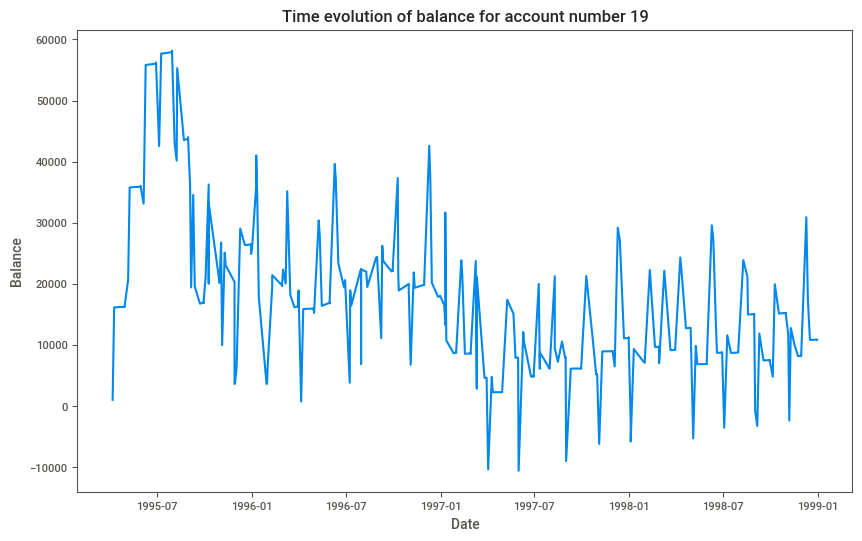

In [654]:
# Plot Zeitliche Entwicklung des Konto-Saldos für die Konto nummer 19
account_19 = trans[trans["account_id"] == 19].copy()  # Create a copy of the DataFrame
# Ensure the date column is in datetime format
account_19["date"] = pd.to_datetime(account_19["date"])

# Sort the values by date
account_19 = account_19.sort_values("date")

plt.figure(figsize=(10, 6))
plt.plot(account_19["date"], account_19["balance"])
plt.title("Time evolution of balance for account number 19")
plt.xlabel("Date")
plt.ylabel("Balance")
plt.show()

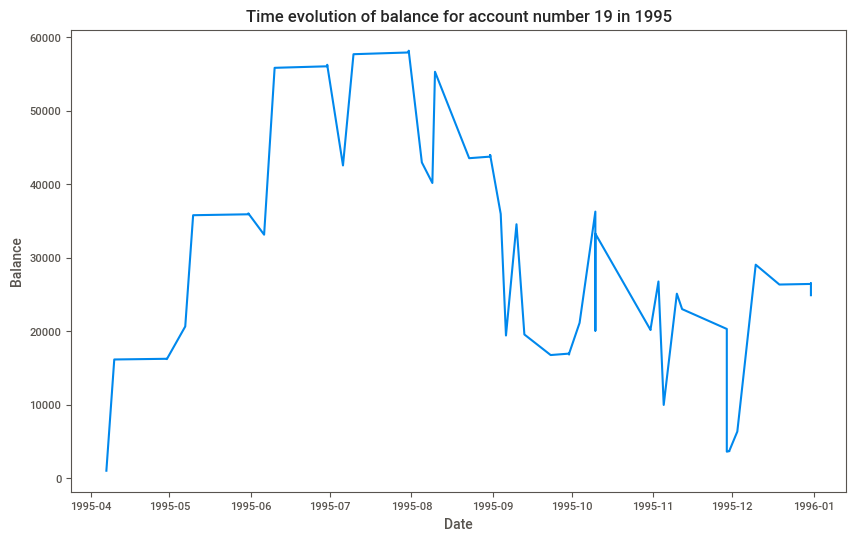

In [655]:
# zoom the year 1995 of the plot
account_19_1995 = account_19[account_19["date"].dt.year == 1995]
# plot it
plt.figure(figsize=(10, 6))
plt.plot(account_19_1995["date"], account_19_1995["balance"])
plt.title("Time evolution of balance for account number 19 in 1995")
plt.xlabel("Date")
plt.ylabel("Balance")
plt.show()

# Wee see that there is a steep line in 1995-10 so there are two transactions, this we have to clean.

### Korrelation & weitere Informationen
Die Korrelation sowie weitere Informationen zu den vorhandenen Daten können aus dem [SweetViz Report](./reports/trans.html) entnommen werden.

# Datenaufbereitung
Im nachfolgenden Abschnitt werden die Daten zu statischen (Kunden-) Daten und transaktionellen (Bankdienstleistungs-) Daten kombiniert um diese anschliessend zusammenzufügen.  
 
## Statische Daten
Hier zusammengefügt wurden die Daten aus 
- `disp.csv`
- `account.csv`
- `client.csv`
- `card.csv`
- `loan.csv` 
- `order.csv`
- `districts.csv`

In [656]:
#TODO 
# merge dataframes
static_data = (
    data_frames["disp.csv"]
    .add_suffix("_disp")
    .merge(
        data_frames["account.csv"].add_suffix("_account"),
        left_on="account_id_disp",
        right_on="account_id_account",
        how="left",
    )
    .merge(
        data_frames["card.csv"].add_suffix("_card"),
        left_on="disp_id_disp",
        right_on="disp_id_card",
        how="left",
    )
    .merge(
        data_frames["loan.csv"].add_suffix("_loan"),
        left_on="account_id_disp",
        right_on="account_id_loan",
        how="left",
    )
    .merge(
        data_frames["order.csv"].add_suffix("_order"),
        left_on="account_id_disp",
        right_on="account_id_order",
        how="left",
    )
)

In [657]:
static_data.columns

Index(['disp_id_disp', 'client_id_disp', 'account_id_disp', 'type_disp',
       'account_id_account', 'district_id_account', 'frequency_account',
       'date_account', 'card_id_card', 'disp_id_card', 'type_card',
       'issued_card', 'loan_id_loan', 'account_id_loan', 'date_loan',
       'amount_loan', 'duration_loan', 'payments_loan', 'status_loan',
       'account_id_order', 'household_order', 'insurance_payment_order',
       'leasing_order', 'loan_payment_order', 'unknown_order'],
      dtype='object')

In [658]:
cols_to_replace_na = [
    "household_order",
    "insurance_payment_order",
    "loan_payment_order",
    "leasing_order",
    "unknown_order",
]

static_data[cols_to_replace_na] = static_data[
    cols_to_replace_na
].fillna(0)

## Dropping of Junior Cards that are not on the edge to a normal card Analyse


In [659]:
# join district and client left join on district_id
static_data = static_data.merge(
    data_frames["district.csv"],
    left_on="district_id_account",
    right_on="district_id",
    how="left",
)

static_data

,disp_id_disp,client_id_disp,account_id_disp,type_disp,account_id_account,district_id_account,frequency_account,date_account,card_id_card,disp_id_card,...,num_of_big_town,num_of_bigger_town,num_of_city,ratio_of_urban,average_salary,unemploy_rate95,unemploy_rate96,n_of_enterpren_per1000_inhabit,no_of_crimes95,no_of_crimes96
0,1,1,1,OWNER,1,18,monthly,1995-03-24,NaN,NaN,...,2,1,4,65.3,8968,2.83,3.35,131,1740.0,1910
1,2,2,2,OWNER,2,1,monthly,1993-02-26,NaN,NaN,...,0,1,1,100.0,12541,0.29,0.43,167,85677.0,99107
2,3,3,2,DISPONENT,2,1,monthly,1993-02-26,NaN,NaN,...,0,1,1,100.0,12541,0.29,0.43,167,85677.0,99107
3,4,4,3,OWNER,3,5,monthly,1997-07-07,NaN,NaN,...,4,1,6,51.4,9307,3.85,4.43,118,2616.0,3040
4,5,5,3,DISPONENT,3,5,monthly,1997-07-07,NaN,NaN,...,4,1,6,51.4,9307,3.85,4.43,118,2616.0,3040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5364,13647,13955,11349,OWNER,11349,1,weekly,1995-05-26,NaN,NaN,...,0,1,1,100.0,12541,0.29,0.43,167,85677.0,99107
5365,13648,13956,11349,DISPONENT,11349,1,weekly,1995-05-26,NaN,NaN,...,0,1,1,100.0,12541,0.29,0.43,167,85677.0,99107
5366,13660,13968,11359,OWNER,11359,61,monthly,1994-10-01,1247.0,13660.0,...,5,1,6,53.8,8814,4.76,5.74,107,2112.0,2059
5367,13663,13971,11362,OWNER,11362,67,monthly,1995-10-14,NaN,NaN,...,6,2,6,63.1,8110,5.77,6.55,109,3244.0,3079


In [660]:
# merge client with suffix
static_data = static_data.merge(
    data_frames["client.csv"].add_suffix("_client"),
    left_on="client_id_disp",
    right_on="client_id_client",
    how="left",
)

In [661]:
static_data["has_card"] = ~static_data["card_id_card"].isna()

# Filter rows where 'has_card' is True
filtered_data = static_data[static_data["has_card"]]

# Check if there are duplicated 'account_id' in the filtered data
duplicated_account_id = filtered_data["account_id_account"].duplicated().sum()

print(duplicated_account_id)

0



## Junior Cards removal

,disp_id_disp,client_id_disp,account_id_disp,type_disp,account_id_account,district_id_account,frequency_account,date_account,card_id_card,disp_id_card,...,unemploy_rate96,n_of_enterpren_per1000_inhabit,no_of_crimes95,no_of_crimes96,client_id_client,district_id_client,gender_client,birth_day_client,age_client,has_card
0,1,1,1,OWNER,1,18,monthly,1995-03-24,NaN,NaN,...,3.35,131,1740.0,1910,1,18,female,1970-12-13,29,False
1,2,2,2,OWNER,2,1,monthly,1993-02-26,NaN,NaN,...,0.43,167,85677.0,99107,2,1,male,1945-02-04,54,False
2,3,3,2,DISPONENT,2,1,monthly,1993-02-26,NaN,NaN,...,0.43,167,85677.0,99107,3,1,female,1940-10-09,59,False
3,4,4,3,OWNER,3,5,monthly,1997-07-07,NaN,NaN,...,4.43,118,2616.0,3040,4,5,male,1956-12-01,43,False
4,5,5,3,DISPONENT,3,5,monthly,1997-07-07,NaN,NaN,...,4.43,118,2616.0,3040,5,5,female,1960-07-03,39,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5364,13647,13955,11349,OWNER,11349,1,weekly,1995-05-26,NaN,NaN,...,0.43,167,85677.0,99107,13955,1,female,1945-10-30,54,False
5365,13648,13956,11349,DISPONENT,11349,1,weekly,1995-05-26,NaN,NaN,...,0.43,167,85677.0,99107,13956,1,male,1943-04-06,56,False
5366,13660,13968,11359,OWNER,11359,61,monthly,1994-10-01,1247.0,13660.0,...,5.74,107,2112.0,2059,13968,61,male,1968-04-13,31,True
5367,13663,13971,11362,OWNER,11362,67,monthly,1995-10-14,NaN,NaN,...,6.55,109,3244.0,3079,13971,67,female,1962-10-19,37,False


,disp_id_disp,client_id_disp,account_id_disp,type_disp,account_id_account,district_id_account,frequency_account,date_account,card_id_card,disp_id_card,...,unemploy_rate96,n_of_enterpren_per1000_inhabit,no_of_crimes95,no_of_crimes96,client_id_client,district_id_client,gender_client,birth_day_client,age_client,has_card
48,51,51,43,OWNER,43,36,monthly,1994-06-12,5.0,51.0,...,4.28,131,5796.0,6132,51,36,female,1979-12-02,20,True
56,60,60,51,OWNER,51,67,monthly,1996-05-11,8.0,60.0,...,6.55,109,3244.0,3079,60,67,male,1980-02-19,19,True
78,83,83,71,OWNER,71,1,monthly,1994-03-05,12.0,83.0,...,0.43,167,85677.0,99107,83,1,female,1978-12-25,21,True
143,153,153,128,OWNER,128,2,monthly,1993-02-19,24.0,153.0,...,1.85,132,2159.0,2674,153,13,female,1981-02-12,18,True
157,167,167,139,OWNER,139,38,weekly,1997-05-15,27.0,167.0,...,8.23,104,2653.0,2822,167,38,female,1978-04-18,21,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5236,11836,12144,9869,OWNER,9869,12,monthly,1993-08-21,1139.0,11836.0,...,4.31,137,3804.0,3868,12144,2,male,1980-11-23,19,True
5299,12781,13089,10644,OWNER,10644,16,monthly,1997-07-12,1194.0,12781.0,...,1.54,107,1874.0,1913,13089,16,female,1979-02-14,20,True
5325,13098,13406,10906,OWNER,10906,76,monthly,1993-11-14,1217.0,13098.0,...,5.88,107,3736.0,2807,13406,42,female,1978-04-18,21,True
5335,13231,13539,11013,OWNER,11013,1,weekly,1993-02-14,1223.0,13231.0,...,0.43,167,85677.0,99107,13539,63,male,1978-09-07,21,True


/var/folders/hf/jp3j88_d64343c9s_6v014_40000gn/T/ipykernel_34018/1454011420.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  junior_cards["age_at_issue"] = (


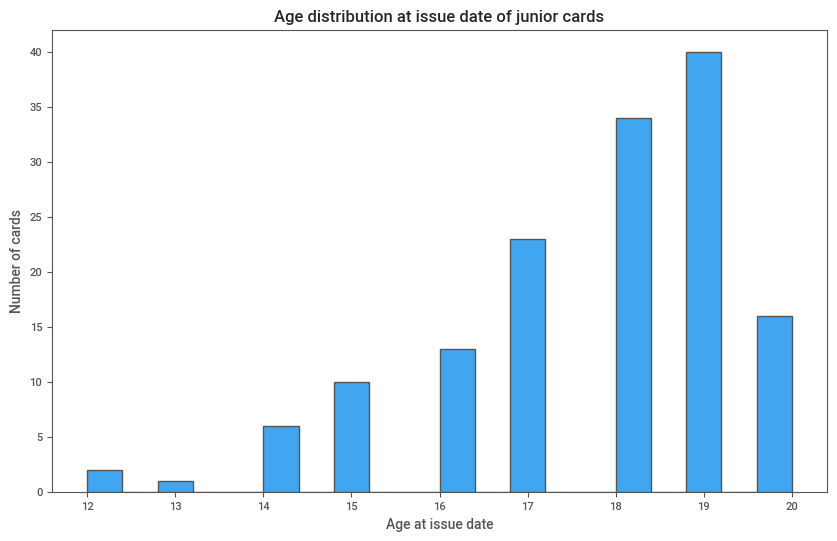

In [662]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

display(static_data)

# Filter rows where 'card_type' contains 'junior' (case insensitive)
junior_cards = static_data[
    static_data["type_card"].str.contains("junior", case=False, na=False)
]

display(junior_cards)

# Calculate age at issue
junior_cards["age_at_issue"] = (
                                       junior_cards["issued_card"] - junior_cards["birth_day_client"]
                               ).dt.days // 365

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=junior_cards, x="age_at_issue", bins=20)
plt.title("Age distribution at issue date of junior cards")
plt.xlabel("Age at issue date")
plt.ylabel("Number of cards")
plt.show()

In the advertising campaign, we do not want to promote children's/junior cards (for whatever reasons). First, I looked at the distribution of age at issuance. Here I see that there are not many junior cards, nor are the cards issued at a late age.

In [663]:
num_accounts_before = len(static_data)
# Filter rows where 'card_type' does not contain 'junior' (case insensitive)
non_transactional_data = static_data[
    ~static_data["type_card"].str.contains("junior", case=False, na=False)
]
num_accounts_after = len(non_transactional_data)
num_junior_cards = num_accounts_before - num_accounts_after
print(f"Number of junior cards removed: {num_junior_cards}")

Number of junior cards removed: 145


## Transaktionen

## Zusammenfügen der Daten

In [664]:
%%capture
import subprocess
import pathlib

try:
    file_path = pathlib.Path(os.path.basename(__file__))
except:
    file_path = pathlib.Path("AML_MC.ipynb")

# Check the file extension
if file_path.suffix == ".py":
    # If it's a Python script, convert it to a notebook
    try:
        subprocess.check_output(["jupytext", "--to", "notebook", str(file_path)])
        print("Converted to notebook.")
    except subprocess.CalledProcessError as e:
        print("Conversion failed. Error message:", e.output)
elif file_path.suffix == ".ipynb":
    # If it's a notebook, convert it to a Python script with cell markers
    try:
        subprocess.check_output(["jupytext", "--to", "py:percent", str(file_path)])
        print("Converted to Python script.")
    except subprocess.CalledProcessError as e:
        print("Conversion failed. Error message:", e.output)
else:
    print("Unsupported file type.")

In [665]:
# Update html output
# jupyter nbconvert --to html --template pj AML_MC.ipynb

# Referenzen
- [1] [Applied Predictive Modelling](http://link.springer.com/10.1007/978-1-4614-6849-3)